In [1]:
# Import all the required packages
import os
import pandas as pd

# Install python-igraph using
# pip install https://github.com/igraph/python-igraph/archive/8864b46849b031a3013764d03e167222963c0f5d.zip
import igraph
from igraph import *

# Hidden package requirement (just need to have them, no need to import)
# cairo (not a python package): installed using Anaconda or from website https://www.cairographics.org/download/
# after cairo installed (important!), install cairocffi using "pip install cairocffi"

In [2]:
# Run pertabation biology (belief-propagation fortran code) using bash script

In [3]:
%%bash
# gfortran needed, install using "brew install gcc"
# compile the fortran code to executable might be needed
# gfortran decima_pp.f -o decima_bp
# Run the pertbio bp code (2 models take ~25s)
# The output files will be generated in the same folder
./decima_bp < input.txt > input.out

In [4]:
# Load input node name/index file
node = pd.read_csv("node_index.txt",sep="\s+",header=None,names=['name','include','type'])
node[13:18]

name  include  type
13     c-Myc        1     1
14      PLK1        1     1
15  S6_pS240        1     1
16    aMEK12        1     3
17      aAKT        1     3

In [5]:
# Load output network model file (adjacency matrix)
topo = pd.read_csv("topology_1.txt",sep="\s+",header=None,names=node['name'])
topo = topo.set_index(node['name'])
topo.iloc[0:5,0:5]

4EBP1_pS65  Rb_pS807  MAPK_pT202  MEK1_2_pS217  AKT_pS473
name                                                                   
4EBP1_pS65             0         1           0             0          0
Rb_pS807               0         0           0             0          0
MAPK_pT202             0         0           0             1          0
MEK1_2_pS217           0         0           0             0          0
AKT_pS473              0         0           0             0          0

In [6]:
# igraph read row as source and column as target 
# use this function to transpose the matrix to fix the directionality
def transp_matrix(filename):
    topo = pd.read_csv(filename + ".txt",sep="\s+",header=None)
    transp = topo.transpose()
    transp.to_csv(filename + "_transpose.txt",sep="\t",header=False,index=False)
transp_matrix('topology_1')
transp_matrix("topology_2")

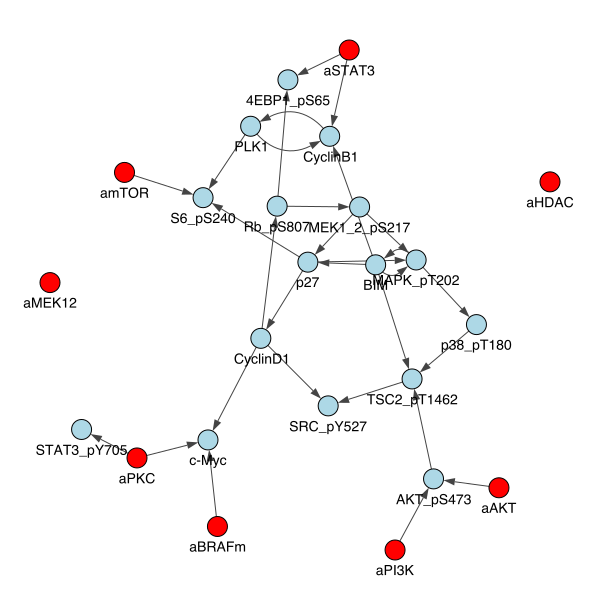

In [7]:
# Read in the adjacency matrix file for the network and set up plotting parameters
def plot_network(filename):
    filename = filename + ".txt"
    g = Graph.Read_Adjacency(filename)
    # Name and color the nodes
    g.vs["name"] = node['name']
    g.vs["label"] = g.vs["name"]
    g.vs["type"] = node['type']
    color_dict = {1:"lightblue",2:"green",3:"red"}
    g.vs["color"]=[color_dict[type] for type in g.vs["type"]]
    # adjust the plotting layout
    layout = g.layout("kk")
    g.vs["label_dist"]=1.5
    g.es["arrow_size"]=0.8
    return g    
# plot the network from the first example model
# example files are pre-generated so that the networks plotted will be consistent
network1 = plot_network("example_topology_1_transpose")
plot(network1,bbox=(600,600),margin=50)

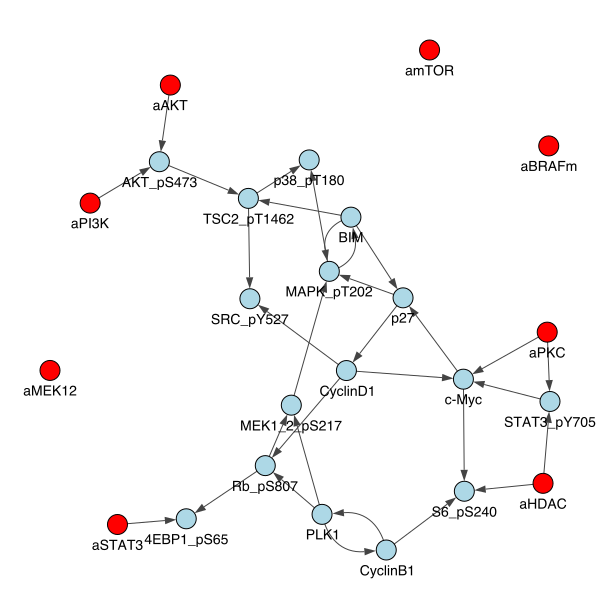

In [8]:
# plot the network from the second example model
network2 = plot_network("example_topology_2_transpose")
plot(network2,bbox=(600,600),margin=50)
# Two models share some edges
# eg. aAKT (AKT inhibitor drug coupling node)/aPI3K (PI3K inhibitor) - AKT_pS473 - TSC2_pT1462
# We know that AKT inhibitor acts on AKT phosphorylation and further affect Tuberin (downstream of mTORC1)
# Two models have different edges 
# eg. in model1, amTOR (mTORi) acts on S6_pS240 but in model2, this interaction was not picked up

In [9]:
# Calculate an average network model from two models (this can be done to as many models as possible)
# Average model is calculated by averaging edge values (how strong the connection between two nodes are)
# over all models, and normalized/divided by the maximum edge value in all models
# A cutoff of 0.2 is chosen as threshold (absolute average edge value > 0.2 is counted as a true interaction)
model1 = pd.read_csv("model_1.txt",sep="\s+",header=None)[0:24]
model_sum = model1
model_max = model1.max().max()
for i in range(2,3):
    new_model = pd.read_csv("model_" + str(i) + ".txt",sep="\s+",header=None)[0:24]
    model_sum = model_sum + new_model
    if (new_model.max().max() > model_max):
        model_max = new_model.max().max()
model_ave = (model_sum/len(range(1,3))/model_max).transpose()
model_ave.to_csv("ave_model.txt",sep="\t",header=False,index=False)
topo_ave = model_ave
topo_ave[abs(topo_ave)>=0.2]=1
topo_ave[abs(topo_ave)<0.2]=0
topo_ave.to_csv("ave_topology.txt",sep="\t",header=False,index=False)

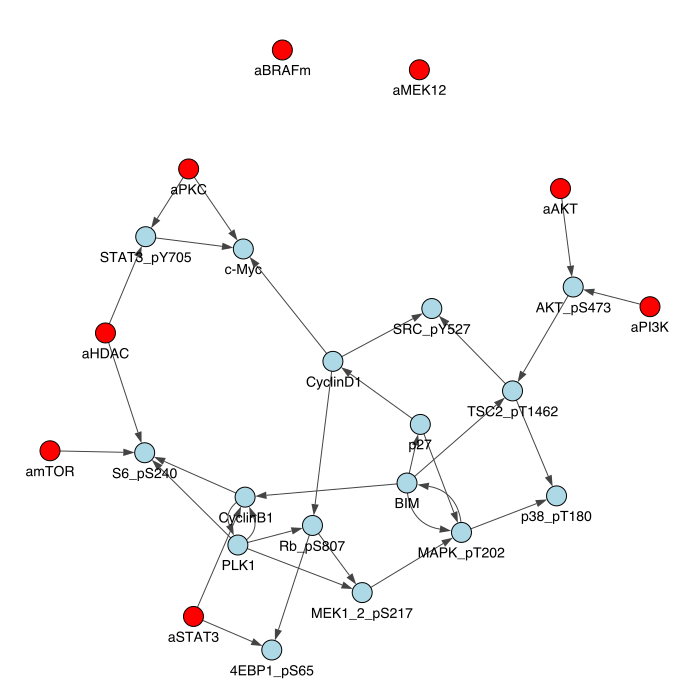

In [10]:
avetopo = plot_network("example_ave_topology")
plot(avetopo,bbox=(700,700),margin=50)
# The average model keeps strong edges from both models and removes noise
# eg. S6_pS240 is kept as a target for mTORi